![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [72]:
!pip install torchmetrics
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
import matplotlib.pyplot as plt

In [74]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [75]:
classes = train_data.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [76]:
num_classes = len(train_data.classes)
print(f"Total number of classes:{num_classes}")
      
image_size = train_data[0][0].shape[1]
print(f"Image size:{image_size}×{image_size}")

Total number of classes:10
Image size:28×28


In [77]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_data, batch_size = batch_size)

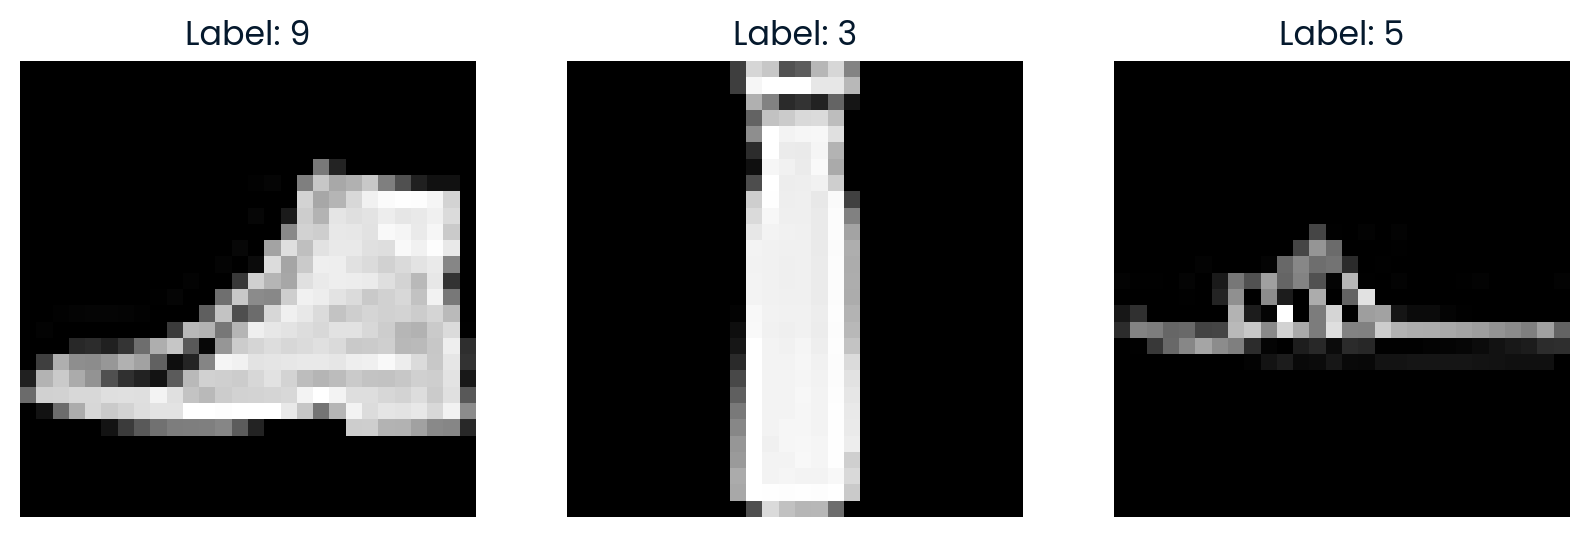

In [78]:
image_examples = iter(train_loader)
images, labels = next(image_examples)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    img = images[i].squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

In [79]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.fc = nn.Linear(16 * (image_size//2)**2, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
        

In [80]:
model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
epochs = 2

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/2, Loss: 0.4553
Epoch 2/2, Loss: 0.3320


In [82]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

In [83]:
accuracy_metric = Accuracy(task="multiclass", num_classes=10)
precision_metric = Precision(task="multiclass", num_classes=10, average=None)
recall_metric = Recall(task="multiclass", num_classes=10, average=None)

predictions_tensor = torch.tensor(predictions)
true_labels_tensor = torch.tensor(true_labels)

accuracy = accuracy_metric(predictions_tensor, true_labels_tensor).item()
precision = precision_metric(predictions_tensor, true_labels_tensor).tolist()
recall = recall_metric(predictions_tensor, true_labels_tensor).tolist()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")

Accuracy: 0.8817
Precision per class: [0.8246816992759705, 0.9769307971000671, 0.794366180896759, 0.8587570786476135, 0.8724428415298462, 0.9883720874786377, 0.6811301708221436, 0.9195837378501892, 0.951361894607544, 0.9560878276824951]
Recall per class: [0.8420000076293945, 0.9739999771118164, 0.8460000157356262, 0.9120000004768372, 0.7250000238418579, 0.9350000023841858, 0.675000011920929, 0.972000002861023, 0.9779999852180481, 0.9580000042915344]
